In [1]:
import numpy as np
import ten
import ipywidgets as widgets
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ["svg"]



$$ m_i = \begin{pmatrix}
1 \\ -1
\end{pmatrix}
$$

In [2]:
temperature = widgets.FloatSlider(min=2, max=5)
temperature

FloatSlider(value=2.0, max=5.0, min=2.0)

In [3]:
D = widgets.IntSlider(value=8, min=8, max=24)
D

IntSlider(value=8, max=24, min=8)

In [4]:
steps = widgets.IntSlider(min=4, max=100)
steps

IntSlider(value=4, min=4)

In [5]:
def trace(t):
	return np.einsum("iijj->", t)

$$ Z = \sum_{i} e^{- \beta ...} = \text{Tr} \prod_i T_{l_i r_i u_i d_i} $$

$$ T^{(0)}_{lrud} = \sum_\alpha W_{\alpha,l} ~ W_{\alpha,r} ~ W_{\alpha,u} ~ W_{\alpha,d}$$

$$ W_{ij} = \begin{pmatrix}
\sqrt{\cosh\left(\frac{1}{t}\right)} & \sqrt{\sinh\left(\frac{1}{t}\right)} \\
\sqrt{\cosh\left(\frac{1}{t}\right)} & -\sqrt{\sinh\left(\frac{1}{t}\right)}
\end{pmatrix}
$$

$$ H^{(0)}_{lrud} = \sum_\alpha W_{\alpha,l} ~ W_{\alpha,r} ~ W_{\alpha,u} ~ W_{\alpha,d} ~ m_\alpha ~~~~ \text{where} ~~~~ m_\alpha = \begin{pmatrix} 1 \\ -1 \end{pmatrix} $$

$$ \text{Magnetization} = \frac{\text{Tr}(H)}{\text{Tr}(Z)} $$


$$ M^{(n)}_{lrud} = \sum_\alpha T^{(n-1)}_{l_1 r_1 u \alpha} T^{(n-1)}_{l_2 r_2 \alpha d} ~~~~ \text{where} ~~~~ l = l_1 \otimes l_2, ~~ r = r_1 \otimes r_2 $$

In [8]:
def M(u: np.ndarray, d: np.ndarray) -> np.ndarray:
	t = np.einsum("abci,deif->adbecf", u, d)
	return t.reshape((t.shape[0]*t.shape[1], t.shape[2]*t.shape[3], t.shape[4], t.shape[5]))


$$ M^{(n)}_{lrud} = \sum_{\alpha \beta \gamma \epsilon} S_{\alpha \beta \gamma \epsilon} U^L_{l,\alpha} U^R_{r,\beta} U^U_{u,\gamma} U^D_{d,\epsilon} $$

$$ \varepsilon_1 = \sum_{i > D} \vert S_{i,:,:,:} \vert^2, ~~~~ \varepsilon_2 = \sum_{j > D} \vert S_{:,j,:,:} \vert^2 $$

$$ \hat{U} = \begin{cases}
U^L, & \varepsilon_1 < \varepsilon_2 \\
U^R, & \text{otherwise}
\end{cases}
$$

$$ T^{(n)}_{lrud} = \sum_{\alpha \beta} \hat{U}_{l,\alpha} M^{(n)}_{\alpha \beta u d} \hat{U}_{r,\beta} $$

magnetization=0.0


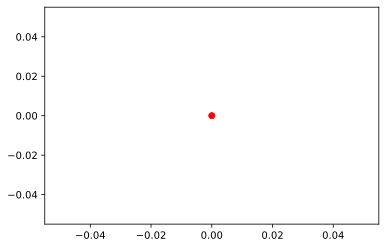

In [12]:
fig = plt.figure()
ax = fig.subplots(1)

T = ten.ising.partition_tensor(temperature.value)
H = ten.ising.magnetization(temperature.value)
magnetization = trace(H)/trace(T)

print(f"{magnetization=}")
ax.plot(0, magnetization, "ro")

for n in range(steps.value):
	Mt = M(T, T)
	Mh = M(H, T)

	S, Us = ten.hosvd(Mt)

	eps1 = sum(np.sum(np.square(np.abs(S[i,:]))) for i in range(D.value, S.shape[0]))
	eps2 = sum(np.sum(np.square(np.abs(S[:,j,:]))) for j in range(D.value, S.shape[1]))

	U = Us[0 if eps1 < eps2 else 1]

	# truncate U
	if U.shape[1] > D.value:
		U = U[:, 0:D.value]
		U = U / np.linalg.norm(U)

	# new T, H
	T = np.einsum("il,ijud,jr->lrud", U, Mt, U)
	H = np.einsum("il,ijud,jr->lrud", U, Mh, U)

	magnetization = trace(H)/trace(T)

	print(f"{magnetization=}")
	ax.plot(n+1, magnetization, "ro")

In [13]:
T

array([[[[2.5430813 , 0.        ],
         [0.        , 1.1752013 ]],

        [[0.        , 1.1752013 ],
         [1.1752013 , 0.        ]]],


       [[[0.        , 1.1752013 ],
         [1.1752013 , 0.        ]],

        [[1.1752013 , 0.        ],
         [0.        , 0.54308057]]]], dtype=float32)

In [14]:
H

array([[[[0.        , 1.72876607],
         [1.72876607, 0.        ]],

        [[1.72876607, 0.        ],
         [0.        , 0.79889233]]],


       [[[1.72876607, 0.        ],
         [0.        , 0.79889233]],

        [[0.        , 0.79889233],
         [0.79889233, 0.        ]]]])